# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA
from scipy.ndimage import convolve

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from timeMethods import *
from gridMethods import *
from trackReconstructionMethods import *
from vertexReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
# fileName = '../build/1800MeV_mu_-1.21x3_1x3.root'
fileName = '../build/multievent_2.root' # 19
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['sensor_wall'            ] = get_photosensor_hits_photosensor_wall        (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)
print('df_hits length:', len(df_hits))

df_hits length: 4778


# Filter Hits

In [6]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Time Bins

In [7]:
time_min = -1
time_max = -1
time_delta = 0.5 # ns
timeBin_min = 0
timeBin_max = 20

if time_min < 0:
    time_min = df_hits['time'].min()
    print('time_min:',time_min)
if time_max < 0:
    time_max = df_hits['time'].max()
    print('time_max:',time_max)
if time_delta != None:
    timeBin_num = int((time_max - time_min) / time_delta)
    print('time_nBins:',timeBin_num)

if time_min >= 0:
    df_hits = df_hits[df_hits['time'] >= time_min].copy()
    df_hits.reset_index(drop=True, inplace=True)
if time_max >= 0:
    df_hits = df_hits[df_hits['time'] <= time_max].copy()
    df_hits.reset_index(drop=True, inplace=True)

df_hits['time_bin'] = pd.cut(df_hits['time'], bins=timeBin_num, labels=False)
df_hits['time_bin'] = df_hits['time_bin'].astype(int)
print(df_hits['time_bin'].head(10))

if timeBin_min != None and timeBin_max != None:
    timeBin_num = timeBin_max - timeBin_min
if timeBin_min != None and timeBin_max != None:
    df_hits = df_hits[(df_hits['time_bin'] >= timeBin_min) & (df_hits['time_bin'] <= timeBin_max)]

df_hits_grouped = df_hits.groupby('time_bin')['time'].count()
deltaT = df_hits_grouped.index[1] - df_hits_grouped.index[0]

print('deltaT:', deltaT)
print('df_hits_grouped.index[0]:', df_hits_grouped.index[0])
print('df_hits_grouped.index[1]:', df_hits_grouped.index[1])

print(df_hits_grouped.head(10))

time_min: 7.147028167027875
time_max: 17451.40335196742
time_nBins: 34888
0    985
1      4
2     29
3     91
4     12
5    259
6     30
7    159
8     44
9     79
Name: time_bin, dtype: int64
deltaT: 1
df_hits_grouped.index[0]: 0
df_hits_grouped.index[1]: 1
time_bin
0     1
1     1
2     3
3     2
4     8
5    10
6     7
7    11
8    12
9    13
Name: time, dtype: int64


# Basic Hit Reco

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)
df_hits = make_relativeVector(df_hits)  

# Plotting Methods

In [9]:
color_oranges = cm.Blues_r  ([0.5,0.6,0.9])
color_blues   = cm.Oranges_r([0.5,0.6,0.9])
blue_1 = "#B6CEC7"
blue_2 = "#92C1A5"
blue_3 = "#889D8E"
red_1  = "#C16464"
red_2  = "#B64D4D"
red_3  = "#FBE6E5"
twilight = cm.twilight(np.linspace(0,1,40))

# Make or Load Grid

In [10]:
gridSize = (40, 40, 40)
makeErrors = False
save = False
savePlots = False
load = False
useWalls = True
plotRecoName = '{}x{}x{}_{}_{}'.format(gridSize[0], gridSize[1], gridSize[2], fileName.split('/')[-1].split('.')[0], {True:'withErrors', False:'noErrors'}[makeErrors])
print('plotRecoName:', plotRecoName)

plotRecoName: 40x40x40_multievent_2_noErrors


In [11]:
# grids, grids_ind, grids_pos = [], [], []
# initialPositions = []

# for timeStep in tqdm.tqdm(range(time_nBins)):
#     if not load:
#         df_hits_time = df_hits[df_hits['time_bin']==timeStep]
#         grid, grid_ind, grid_pos = get_voxelGrid(
#             gridSize,
#             DETECTOR_SIZE_MM,
#             np.array(df_hits_time['sensor_position'].to_list()).reshape(-1,3),
#             np.array(df_hits_time['reconstructedVector_direction'].to_list()).reshape(-1,3),
#             [1 for i in range(len(df_hits_time))],
#             makeErrors,
#             useWalls,
#             df_hits_time['sensor_wall'].to_numpy(),
#             expNWalls
#         )
#         grids    .append(grid    )
#         grids_ind.append(grid_ind)
#         grids_pos.append(grid_pos)
        
#         if save:
#             np.savez('data/{}_{}.npz'.format(plotRecoName, timeStep), grid=grid, grid_ind=grid_ind, grid_pos=grid_pos)

#     else:
#         data = np.load('data/{}_{}.npz'.format(plotRecoName, timeStep))
#         grid     = data['grid'    ]
#         grid_ind = data['grid_ind']
#         grid_pos = data['grid_pos']
#         grids    .append(grid    )
#         grids_ind.append(grid_ind)
#         grids_pos.append(grid_pos)

#     initialPositions.append(np.reshape(df_hits_time['initialPosition'].to_list(), (-1,3)))

grids, grids_ind, grids_pos, initialPositions = make_voxelGrids_withTimeSteps(
    df_hits, 
    timeBin_num,
    shape=gridSize,
    detectorDimensions=DETECTOR_SIZE_MM,
    make_errors=makeErrors,
    useWalls=useWalls,
    wallOperation=expNWalls
)

for grid in grids:
    grid = convolve(grid, np.ones((3,3,3)), mode='constant', cval=0.0)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 11.91it/s]


saving
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0


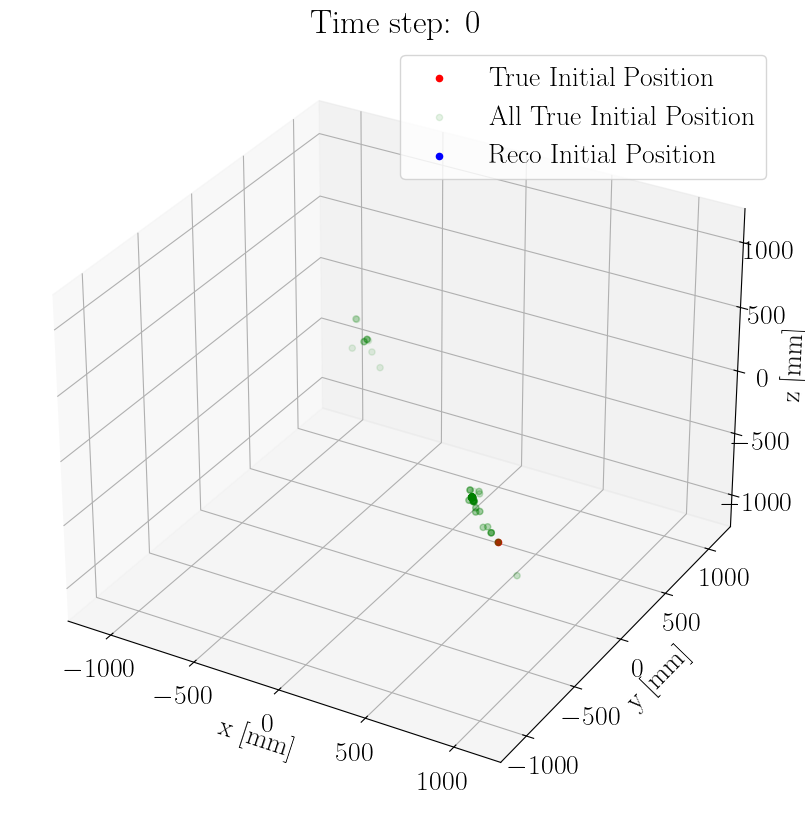

In [12]:
%matplotlib inline

nMaxTimes = 100
if nMaxTimes > len(grids):
    nMaxTimes = len(grids)
saveGif = True

if nMaxTimes < 0:
    nMaxTimes = len(grids)

for i in range(len(grids_pos)):
    if savePlots:
        fig_plt = plt.figure(figsize=(10,10))
        ax_plt = fig_plt.add_subplot(111, projection='3d')
        ax_plt.set_xlim(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2)
        ax_plt.set_ylim(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2)
        ax_plt.set_zlim(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2)
        ax_plt.set_xlabel('x [mm]')
        ax_plt.set_ylabel('y [mm]')
        ax_plt.set_zlabel('z [mm]')
        ax_plt.set_title('Time step: {}'.format(i))
        nonZeroInd = np.where(np.reshape(grids[i], -1) > 0)
        ax_plt.scatter(initialPositions[i][:, 0], initialPositions[i][:, 1], initialPositions[i][:, 2], c='r', label='Initial position')
        ax_plt.scatter(grids_pos[i][nonZeroInd, 0], grids_pos[i][nonZeroInd, 1], grids_pos[i][nonZeroInd, 2], c='b', label='Hits')
        plt.legend()
        plt.savefig('../figures/timeSlice_{}.pdf'.format(i))
        plt.show()

if saveGif:
    fig_gif = plt.figure(figsize=(10, 10))
    ax_gif = fig_gif.add_subplot(111, projection='3d')
    ax_gif.set_xlim(-DETECTOR_SIZE_MM[0] / 2, DETECTOR_SIZE_MM[0] / 2)
    ax_gif.set_ylim(-DETECTOR_SIZE_MM[1] / 2, DETECTOR_SIZE_MM[1] / 2)
    ax_gif.set_zlim(-DETECTOR_SIZE_MM[2] / 2, DETECTOR_SIZE_MM[2] / 2)
    ax_gif.set_xlabel('x [mm]')
    ax_gif.set_ylabel('y [mm]')
    ax_gif.set_zlabel('z [mm]')
    ax_gif.set_title('Time step: 0')
    nonZeroInd = np.where(np.reshape(grids[0], -1) > 0)
    initPosScatter = ax_gif.scatter(initialPositions[0][:, 0], initialPositions[0][:, 1], initialPositions[0][:, 2],
                                    c='r', label='True Initial Position')
    initialPositionsAll = np.array(df_hits['initialPosition'].to_list()).reshape(-1, 3)
    allPosScatter = ax_gif.scatter(initialPositionsAll[:, 0], initialPositionsAll[:, 1], initialPositionsAll[:, 2], c='green', label='All True Initial Position', alpha=0.1)
    girdPosScatter = ax_gif.scatter(grids_pos[0][nonZeroInd, 0], grids_pos[0][nonZeroInd, 1],
                                    grids_pos[0][nonZeroInd, 2], c='b', label='Reco Initial Position')

    def update(i):
        print(i)
        ax_gif.clear()
        ax_gif.set_xlim(-DETECTOR_SIZE_MM[0] / 2, DETECTOR_SIZE_MM[0] / 2)
        ax_gif.set_ylim(-DETECTOR_SIZE_MM[1] / 2, DETECTOR_SIZE_MM[1] / 2)
        ax_gif.set_zlim(-DETECTOR_SIZE_MM[2] / 2, DETECTOR_SIZE_MM[2] / 2)
        ax_gif.set_xlabel('x [mm]')
        ax_gif.set_ylabel('y [mm]')
        ax_gif.set_zlabel('z [mm]')
        ax_gif.set_title('Time step: {}'.format(i))
        nonZeroInd = np.where(np.reshape(grids[i], -1) > 0)
        initPosScatter = ax_gif.scatter(initialPositions[i][:, 0], initialPositions[i][:, 1], initialPositions[i][:, 2],
                                        c='r', label='True Initial Position')
        allPosScatter = ax_gif.scatter(initialPositionsAll[:, 0], initialPositionsAll[:, 1], initialPositionsAll[:, 2],
                                        c='green', label='All True Initial Position', alpha=0.1)
        girdPosScatter = ax_gif.scatter(grids_pos[i][nonZeroInd, 0], grids_pos[i][nonZeroInd, 1],
                                        grids_pos[i][nonZeroInd, 2], c='b', label='Reco Initial Position')
        ax_gif.legend()
        return initPosScatter, girdPosScatter

    ani = FuncAnimation(fig_gif, update, frames=range(nMaxTimes), blit=False)
    print('saving')
    ani.save('../figures/timeSlice.gif', writer='pillow', fps=5)


In [13]:
%matplotlib qt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2)
ax.set_ylim(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2)
ax.set_zlim(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2)
ax.set_title('Reconstructed position')

gridSum = np.sum(grids[:nMaxTimes], axis=0)
gridSum = convolve(gridSum, np.ones((2,2,2)), mode='constant', cval=0.0)
gridSum[gridSum < 4] = 0

nonZeroInd = np.where(np.reshape(gridSum, -1) > 0)
gridCols = ax.scatter(grids_pos[0][nonZeroInd, 0], grids_pos[0][nonZeroInd, 1], grids_pos[0][nonZeroInd, 2], c=np.reshape(gridSum, -1)[nonZeroInd], cmap=cm.plasma)
# gridCols = ax.scatter(grids_pos[0][:, 0], grids_pos[0][:, 1], grids_pos[0][:, 2], c=np.reshape(gridSum, -1), alpha=np.reshape(gridSum, -1) > 0, cmap=cm.plasma)
initPos = np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)
ax.scatter(initPos[:, 0], initPos[:, 1], initPos[:, 2], c='r', label='True Initial Position', alpha=0.2)
plt.legend()
plt.colorbar(gridCols)
plt.savefig('../figures/timeSliceCumulative.pdf', bbox_inches='tight')
plt.show()
